In [70]:
import matplotlib.pyplot as plt

from keras.applications.resnet import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [71]:
NUM_CLASSES = 18

IMAGE_SIZE = 120

RESNET_INPUT_SIZE = 224

DATASET_PATH = "data/images/pokemon_per_type"

FC_SIZE = 1024
NB_RN_LAYERS_TO_FREEZE = 170 # len(ResNet50.layers) return 175 we keep the 5 last ones

In [72]:
def add_new_last_layer(base_model, nb_classes):
    """
    Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def setup_to_transfer_learn(model, base_model):
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
def setup_to_finetune(model):
    for layer in model.layers[:NB_RN_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_RN_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   rotation_range = 20,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(DATASET_PATH + '/train', 
                                                    target_size = (RESNET_INPUT_SIZE, RESNET_INPUT_SIZE), 
                                                    batch_size = 16)
val_set = val_datagen.flow_from_directory(DATASET_PATH + '/val',
                                                target_size = (RESNET_INPUT_SIZE, RESNET_INPUT_SIZE),
                                                 batch_size = 16)

Found 984 images belonging to 18 classes.
Found 230 images belonging to 18 classes.


In [75]:
# setup model
base_model = ResNet50(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_new_last_layer(base_model, NUM_CLASSES)


In [76]:
TL_NB_EPOCHS = 200
TL_STEPS_PER_EPOCH = 10
TL_VAL_STEPS = 2

FT_NB_EPOCHS = 400
tl_STEPS_PER_EPOCH = 10
tl_VAL_STEPS = 2

# transfer learning
setup_to_transfer_learn(model, base_model)

history_tl = model.fit(
training_set,
steps_per_epoch = TL_STEPS_PER_EPOCH,
epochs = TL_NB_EPOCHS,
validation_data = val_set,
shuffle = 0,
validation_steps = TL_VAL_STEPS)

# fine-tuning
setup_to_finetune(model)

history_ft = model.fit(
training_set,
steps_per_epoch = FT_STEPS_PER_EPOCH,
epochs = FT_NB_EPOCHS,
validation_data = val_set,
shuffle = 0,
validation_steps = FT_VAL_STEPS)


Epoch 1/200
10/10 [==============================] - 33s 3s/step - loss: 3.3275 - accuracy: 0.0812 - val_loss: 3.5174 - val_accuracy: 0.0312
Epoch 2/200
10/10 [==============================] - 26s 3s/step - loss: 3.0082 - accuracy: 0.0812 - val_loss: 3.0618 - val_accuracy: 0.0312
Epoch 3/200
10/10 [==============================] - 29s 3s/step - loss: 2.9719 - accuracy: 0.0688 - val_loss: 2.8203 - val_accuracy: 0.0625
Epoch 4/200
10/10 [==============================] - 28s 3s/step - loss: 2.9224 - accuracy: 0.1187 - val_loss: 2.8161 - val_accuracy: 0.1250
Epoch 5/200
10/10 [==============================] - 27s 3s/step - loss: 2.8720 - accuracy: 0.0750 - val_loss: 2.9126 - val_accuracy: 0.0938
Epoch 6/200
10/10 [==============================] - 27s 3s/step - loss: 2.8859 - accuracy: 0.1437 - val_loss: 2.9009 - val_accuracy: 0.1250
Epoch 7/200
10/10 [==============================] - 26s 3s/step - loss: 2.9489 - accuracy: 0.0750 - val_loss: 3.0174 - val_accuracy: 0.0312
Epoch 8/200
1

In [77]:
acc_tl = history_tl.history['accuracy']
val_acc_tl = history_tl.history['val_accuracy']
loss_tl = history_tl.history['loss']
val_loss_tl = history_tl.history['val_loss']
epochs_tl = range(len(acc_tl))

acc_ft = history_ft.history['accuracy']
val_acc_ft = history_ft.history['val_accuracy']
loss_ft = history_ft.history['loss']
val_loss_ft = history_ft.history['val_loss']
epochs_ft = range(len(acc_ft))

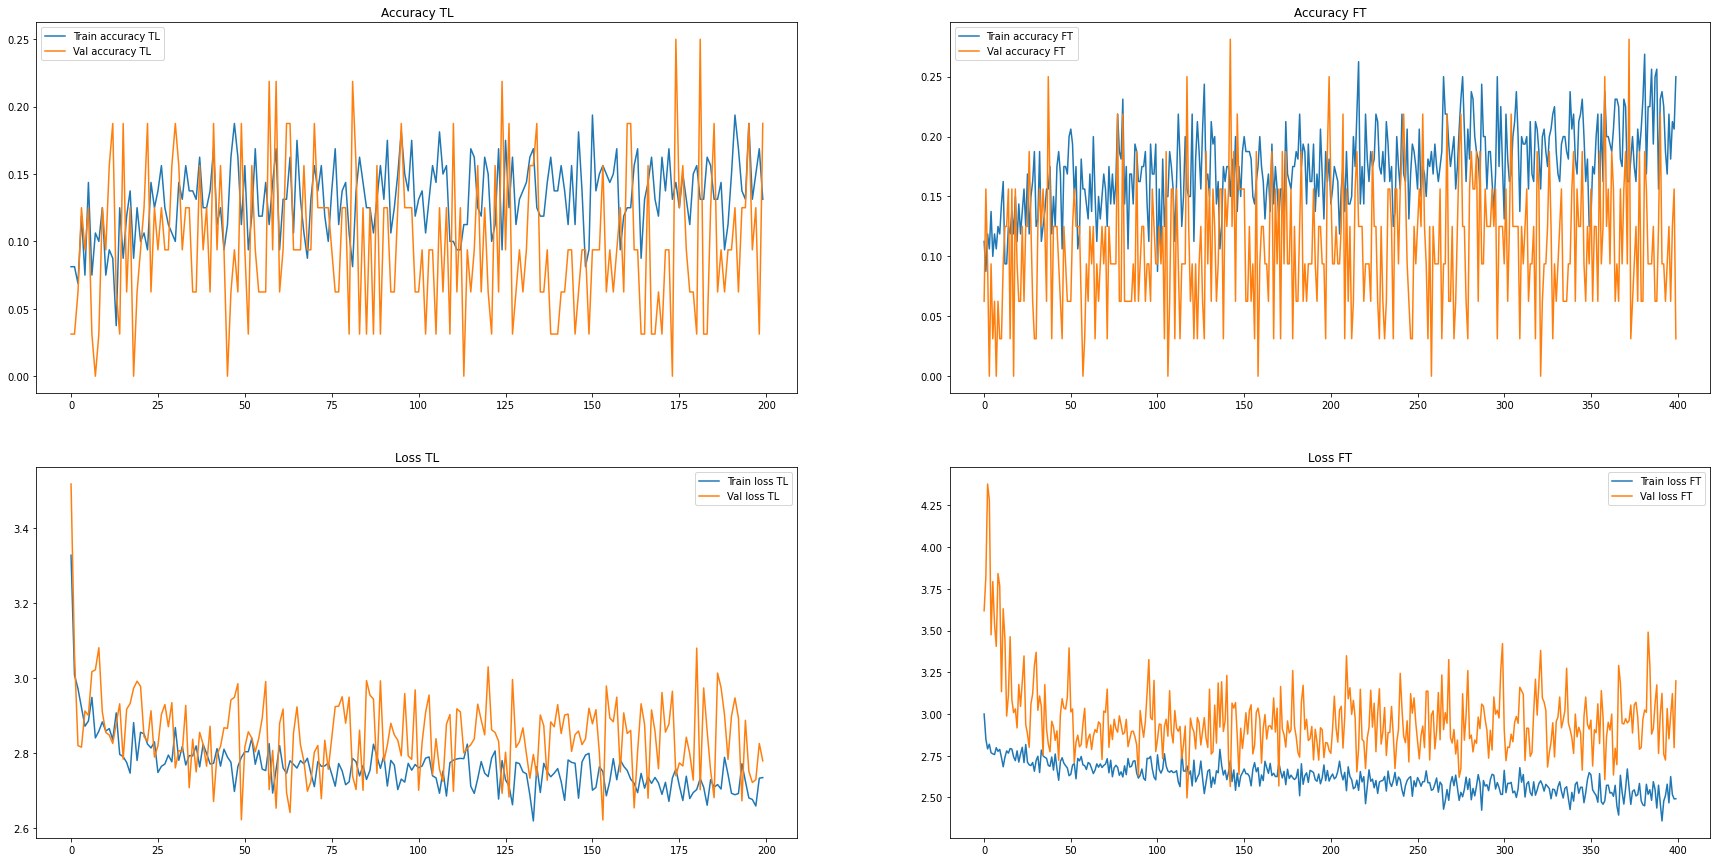

In [78]:
fig, ax = plt.subplots(2, 2, figsize = (30,15))

ax[0,0].plot(epochs_tl, acc_tl, label = "Train accuracy TL")
ax[0,0].plot(epochs_tl, val_acc_tl, label = "Val accuracy TL")
ax[0,0].legend()
ax[0,0].title.set_text("Accuracy TL")

ax[0,1].plot(epochs_ft, acc_ft, label = "Train accuracy FT")
ax[0,1].plot(epochs_ft, val_acc_ft, label = "Val accuracy FT")
ax[0,1].legend()
ax[0,1].title.set_text("Accuracy FT")


ax[1,0].plot(epochs_tl, loss_tl, label = "Train loss TL" )
ax[1,0].plot(epochs_tl, val_loss_tl,  label = "Val loss TL")
ax[1,0].legend()
ax[1,0].title.set_text("Loss TL")

ax[1,1].plot(epochs_ft, loss_ft, label = "Train loss FT" )
ax[1,1].plot(epochs_ft, val_loss_ft,  label = "Val loss FT")
ax[1,1].legend()
ax[1,1].title.set_text("Loss FT")


In [79]:
# model.save(args.output_model_file)